<a href="https://colab.research.google.com/github/hmelberg/health-analytics-using-python/blob/dev/5_Typical_Treatment_Part_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Describe and visualize typical treatment paths

Hans Olav Melberg, Nashville, November, 2019


---



---



## Background

Given the multitude of different types of treatments a patient receives and the many methods for visualizing these treatments, it might be useful to anchor our thoughts in one specific case and then use the lessons from this case to  develop a more general method to describe a typical treatment path.

The case we we will use, is the treatment of patients with inflammatory bowel disease (IBD).

It is often beneficial to know a few datails about the disease, in order not to make stupid mistakes in the analysis, and to be able to ask slightly more intelligent questions when looking at the data. Here is six minutes of IBD wisdom:





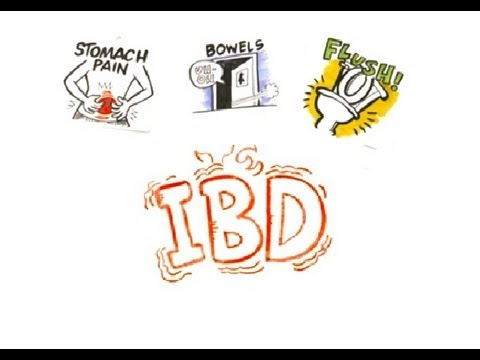

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('Keqzt83KMVA')

The guidelines for treating IBD-patients often recommen following a treatment pyramid, starting with a group og pharmaceuticals called 5-ASA and if that does not work well, the next step is a group of immunomodulators, and lastly, if that does not work the patient is given so-collat biological pharmaceuticals. The pyramid, and the reasoning behind, is explained in this one minute video:

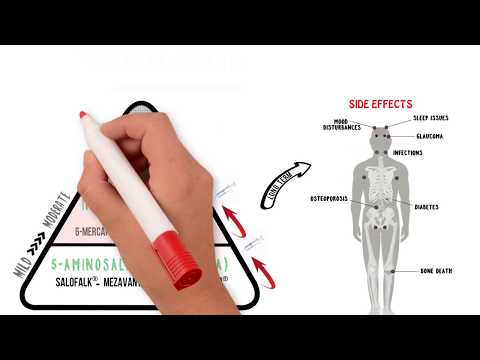

In [0]:

YouTubeVideo('2y-JvRHstFk')


An interesting question we might ask, is whether the actual treatment path follows the recommended treatment path as it is described in the treatment pyramid. 

To answer this we first get some (synthetic) data from hospitals that we can use to identify all IBD patients (i.e. those that have ICD 9 codes starting with 555 and 556). We then collect information about all the prescriptions these patients have received from another datafile. Lastly, we have to find an efficient method to summarize and visualize the treatment path for these patients.



Import libraries to be used




In [0]:
import pandas as pd
import numpy as np

Read synthetic medicare sample data on inpatient hospital stays

In [0]:
path = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
inpatient_file = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip'

inpatient = pd.read_csv(path+inpatient_file)


Initial data preparation

In [0]:
# lower case column names
inpatient.columns=inpatient.columns.str.lower()

# easier to use pid than desynpuf_id
inpatient['pid']=inpatient.desynpuf_id

# useful to have pid in the index  
inpatient=inpatient.set_index('pid', drop=False)
inpatient.index.name='pid_index'

# create a date variable
date_as_string = inpatient.clm_from_dt.astype('Int64').astype(str)
inpatient['date'] = pd.to_datetime(date_as_string, 
                                   format='%Y/%m/%d', 
                                   errors='coerce')
# sort on date
inpatient = inpatient.sort_values(['pid', 'date'])


In [0]:
inpatient.head()

,desynpuf_id,clm_id,segment,clm_from_dt,clm_thru_dt,prvdr_num,clm_pmt_amt,nch_prmry_pyr_clm_pd_amt,at_physn_npi,op_physn_npi,ot_physn_npi,clm_admsn_dt,admtng_icd9_dgns_cd,clm_pass_thru_per_diem_amt,nch_bene_ip_ddctbl_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_blood_ddctbl_lblty_am,clm_utlztn_day_cnt,nch_bene_dschrg_dt,clm_drg_cd,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10,icd9_prcdr_cd_1,icd9_prcdr_cd_2,icd9_prcdr_cd_3,icd9_prcdr_cd_4,icd9_prcdr_cd_5,icd9_prcdr_cd_6,hcpcs_cd_1,hcpcs_cd_2,hcpcs_cd_3,hcpcs_cd_4,...,hcpcs_cd_8,hcpcs_cd_9,hcpcs_cd_10,hcpcs_cd_11,hcpcs_cd_12,hcpcs_cd_13,hcpcs_cd_14,hcpcs_cd_15,hcpcs_cd_16,hcpcs_cd_17,hcpcs_cd_18,hcpcs_cd_19,hcpcs_cd_20,hcpcs_cd_21,hcpcs_cd_22,hcpcs_cd_23,hcpcs_cd_24,hcpcs_cd_25,hcpcs_cd_26,hcpcs_cd_27,hcpcs_cd_28,hcpcs_cd_29,hcpcs_cd_30,hcpcs_cd_31,hcpcs_cd_32,hcpcs_cd_33,hcpcs_cd_34,hcpcs_cd_35,hcpcs_cd_36,hcpcs_cd_37,hcpcs_cd_38,hcpcs_cd_39,hcpcs_cd_40,hcpcs_cd_41,hcpcs_cd_42,hcpcs_cd_43,hcpcs_cd_44,hcpcs_cd_45,pid,date
pid_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00013D2EFD8E45D1,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,NaN,NaN,20100312,4580,0.0,1100.0,0.0,0.0,1.0,20100313,217,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00013D2EFD8E45D1,2010-03-12
00016F745862898F,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,NaN,NaN,20090412,7866,0.0,1068.0,0.0,0.0,6.0,20090418,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F,2009-04-12
00016F745862898F,00016F745862898F,196661177015632,1,20090831.0,20090902.0,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,NaN,20090831,6186,0.0,1068.0,0.0,0.0,2.0,20090902,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,6186,V5866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F,2009-08-31
00016F745862898F,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,NaN,1.119000e+09,20090917,29590,0.0,1068.0,0.0,0.0,3.0,20090920,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F,2009-09-17
00016F745862898F,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,NaN,20100626,5849,0.0,1100.0,0.0,0.0,5.0,20100701,983,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN,NaN,E8889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00016F745862898F,2010-06-26


We also need the codebook for the ICD 9 diagnosis:

In [0]:
icd9_codebook = pd.read_csv('https://www.nber.org/data/ICD9ProviderDiagnosticCodes/2010/icd9dx2010.csv')
icd9_codebook.head()

,dgns_cd,shortdesc,version,fyear
0,0010,Cholera d/t vib cholerae,27,2010
1,0011,Cholera d/t vib el tor,27,2010
2,0019,Cholera NOS,27,2010
3,0020,Typhoid fever,27,2010
4,0021,Paratyphoid fever a,27,2010


In [0]:
icd2text = icd9_codebook.set_index('dgns_cd').shortdesc.to_dict()

In [0]:
# Testing that the codebook works
inpatient.icd9_dgns_cd_1.value_counts().rename(index=icd2text)

Pneumonia, organism NOS     2453
Rehabilitation proc NEC     1807
Crnry athrscl natve vssl    1675
Septicemia NOS              1648
Obs chr bronc w(ac) exac    1558
                            ... 
Inj post tibial artery         1
2nd deg burn face NEC          1
Myelofi w myelo metaplas       1
Brain hem opn w/o coma         1
Iatrogen hypothyroid NEC       1
Name: icd9_dgns_cd_1, Length: 2740, dtype: int64

In [0]:
#crohn's disease: 555x
cd_codes = [code for code, name in icd2text.items() if code.startswith('555')]
#ulcerative colitis: 556x
uc_codes = [code for code, name in icd2text.items() if code.startswith('556')]
ibd_codes = cd_codes + uc_codes



In [0]:
# just checking!
ibd_codes

['5550',
 '5551',
 '5552',
 '5559',
 '5560',
 '5561',
 '5562',
 '5563',
 '5564',
 '5565',
 '5566',
 '5568',
 '5569']

## Step 1: Find all patients who have IBD

In [0]:
# Columns with diagnostic codes
icd_columns = ['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4',
       'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8',
       'icd9_dgns_cd_9', 'icd9_dgns_cd_10']

In [0]:
# Mark rows with IBD diagnostic codes
ibd_rows = inpatient[icd_columns].isin(ibd_codes).any(axis=1)

In [0]:
# Select the personal id from the rows with an IBD diagnostic code
ibd_pids = inpatient[ibd_rows].pid.unique()
ibd_pids

## Step 2: Get all the prescriptions the IBD patients have received

We could read the whole dataframe with prescriptions for all patients, but this sometimes takes too much memory and also a long time. Instead, we will demonstrate a method that you can use to read the parts of the file that is relevant. In short we will read the file in two steps:
1. First we will only read one column from the file with all the prescriptions and that is the column with the personal identifier. For .csv. files this can be done using the argument *usecols=[COLUMN_NAME]* in the *read_csv()* function.

2. We know that only those rows with a personal identifier that belongs to IBD patients are relevant, so we make a list of the line numbers that correspond to the rows that does not belong to IBD patients. This is useful because the *read_csv()* function in Pandas has an argument that allows us to skip certain rows based on their line number; The *skiprows = [LIST OF LINE NUMBERS TO BE SKIPPED]* argument. Using this *skiprows* we read all the column, but only for the rows that are relevant i.e. rows with prescriptions that went to patients who had been diagnosed with IBD.

In [0]:
# Good approach to avoid memory problems 
# when you only need parts of a larger datafile

# First: Read only the column with the personal id number (usecols)
path= 'http://downloads.cms.gov/files/'
rx_file = 'DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_1.zip'
rx = pd.read_csv(path+rx_file, usecols =['DESYNPUF_ID'])

# Second: Determine the row numbers that do not belong to patients with IBD 
ibd_patient_rows = rx['DESYNPUF_ID'].isin(ibd_pids)
rows_not_ibd_person = np.arange(1, len(rx)+1)[~ibd_patient_rows]

# Read all columns in the file, but only for the relevant patients 
# (skip the other rows)
rx = pd.read_csv(path+rx_file, skiprows=rows_not_ibd_person, header=0)


Clean the file

In [0]:
# lower case column names
rx.columns=rx.columns.str.lower()

# easier to use pid than desynpuf_id
rx['pid']=rx.desynpuf_id

# useful to have pid in index when 
rx=rx.set_index('pid', drop=False)
rx.index.name='pid_index'

# create a date column
rx['date'] = pd.to_datetime(rx.srvc_dt.astype(str), format='%Y/%m/%d')

# sort by date
rx=rx.sort_values(['pid', 'date'])


## Step 3: Identify order of treatments

To identify the relevant NDC codes for 5-ASA and the other groups of pharmaceuticals, we need the codebook:

In [0]:
# Read codebooks for NDC codes
ndc_codebook = pd.read_csv('https://www.nber.org/fda/ndc/product.csv', encoding='latin-1')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The NDC is composed of a code for the labeler, the product, and the package. We are interested in the product, not the size of the product, so we focus on the first two which is enough to uniquely identify a type of pharmaceutical. We also have to make sure that the number has zeros in front, since they are sometimes lost when reading numbers. That is why we use the *zfill()* method. There are different standards for making these codes, and we make sure that we use the standard where the labeler has 5 digits (including leading zeros) and the product has 4 digits (including leading zeros):

In [0]:
label = ndc_codebook.ndc.str.split('-').str[0].str.zfill(5)
product = ndc_codebook.ndc.str.split('-').str[1].str.zfill(4)

ndc_codebook['label_and_product'] = label + product

ndc2text = (ndc_codebook.set_index('label_and_product')
                .npropname
                .str.lower()
                .to_dict())



Given that the codeook identifies the drug using only the labeler code and the product code, we need to make the same column in the prescription dataframe:

In [0]:
rx['label_and_product'] = (rx.prod_srvc_id
                             .astype(str)
                             .str.zfill(11)
                             .str[:9])

# insert the actual name in the dataframe 
# (no problem with small files)
rx['name'] = rx.label_and_product.map(ndc2text)

#just checking that we have a good codefile and matching dataframe
rx.name.value_counts()

oxygen                               198
simvastatin                          174
metformin hydrochloride               94
lovastatin                            89
lisinopril                            85
                                    ... 
acetaminophen, codeine phosphate       1
adalimumab                             1
mexican tea pollen                     1
oxycodone and aspirin                  1
acetaminophen,diphenhydramine hcl      1
Name: name, Length: 1310, dtype: int64

From the NDC codebook, we can identify the codes related to 5-ASA, immunomodulators and biologics.

In [0]:
asa_rows = ndc_codebook.npropname.str.contains('mesalamine', case=False, na=False)

asa_codes = set(ndc_codebook[asa_rows].label_and_product)
asa_codes


In [0]:
immuno_generics = ['azathioprine', 
                  'mercaptopurine', 
                  'methotrexate sodium']

immuno_regex = '|'.join(immuno_generics)

immuno_rows = ndc_codebook.npropname.str.contains(immuno_regex, 
                                                  case=False, 
                                                  na=False)

immuno_codes = set(ndc_codebook[immuno_rows].label_and_product)
immuno_codes

In [0]:
bio_names = '''adalimumab,
               certolizumab, 
               golimumab,
               infliximab,
               natalizumab,
               vedolizumab,
               ustekinumab'''.split(',')


bio_regex = '|'.join(bio_names)

bio_rows = ndc_codebook.npropname.str.contains(bio_regex, 
                                               case=False, 
                                               na=False)

bio_codes = set(ndc_codebook[bio_rows].label_and_product)
bio_codes

Although the synthetic data are related to the true data in the sense that it has roughly the same distribution of single variables, it does not maintain the connection between variables. Patients with a disease in our data does not necessarily receive the relevant pharmaceuticals. We see this when we check for how many of our more than 400 patients who have received one or more of the relevant pharmaceuticals:

In [0]:
n_events = len(rx)
n_patients=rx.pid.nunique()
n_asa = (rx.label_and_product.isin(asa_codes)).sum()
n_immuno = (rx.label_and_product.isin(immuno_codes)).sum()
n_bio = (rx.label_and_product.isin(bio_codes)).sum()
print(f'patients {n_patients}',
      f'events {n_events}' 
      f'... with asa {n_asa}', 
      f'... with immuno {n_immuno}', 
      f'... with bio {n_bio}')

patients 462 events 30426... with asa 757 ... with immuno 324 ... with bio 213


In order to illustrate the methods, we need more events with the pharmaceuticals we are interested in, and for the sake of illustration we will extend the code groups to include more codes.

In [0]:
# making the events more frequent by including differnt codes
fake_asa_codes = rx[rx.name.str.contains('as', na=False)].label_and_product.unique()
fake_immuno_codes = rx[rx.name.str.contains('im', na=False)].label_and_product.unique()
fake_bio_codes = rx[rx.name.str.contains('bi', na=False)].label_and_product.unique()


In [0]:
asa_codes = list(asa_codes) + list(fake_asa_codes)
immuno_codes = list(immuno_codes) + list(fake_immuno_codes)
bio_codes = list(bio_codes) + list(fake_bio_codes)

In [0]:
# Recalculate the rows based on the new codes
asa_rows = rx.label_and_product.isin(asa_codes)
immuno_rows = rx.label_and_product.isin(immuno_codes)
bio_rows = rx.label_and_product.isin(bio_codes)

# create a pharma row with a single letter that 
# indicates the type of pharmaceutical used in the row
rx.loc[asa_rows, 'pharma'] = 'a'
rx.loc[immuno_rows, 'pharma'] = 'i'
rx.loc[bio_rows, 'pharma'] = 'b'

# A suprisingly brief and efficient approach to summarize the 
# treatment receivec byb each individual in a single string
# just sum the characters in the pharma column for each person!
pharma_order = rx.pharma.dropna().groupby(level=0).sum()
pharma_order

pid_index
0076A3B03FA644E9         bi
00B22C471486C580      babia
00D3EFAF79074DAE          b
032028E477C3DECE    abaibab
03FF407305A935CE          a
                     ...   
F7389857DE9E1C4C          i
FA529C2A1EC821B3          i
FB075DB13A7173A0         ib
FB9706AEB2E28E35       ibia
FD11481CE556EC6B      aabbb
Name: pharma, Length: 286, dtype: object

## What is the most common treatment pattern?

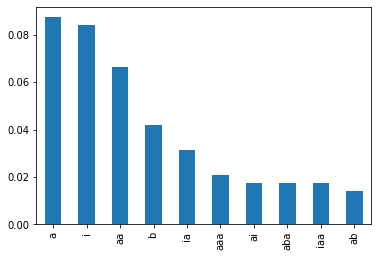

In [0]:
pharma_order.value_counts(normalize=True).head(10).plot.bar();
# exercise: split by date of diagnosis to get patietns with same follow up time

### What is the most common first line pharmaceutical?

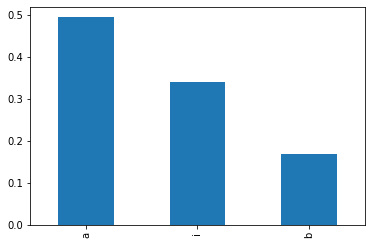

In [0]:
pharma_order.str[0].value_counts(normalize=True).head(10).plot.bar();


### What is the most common pattern if we look at only 1st and 2nd line?

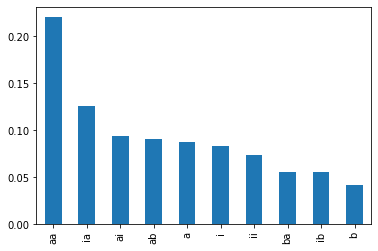

In [0]:
pharma_order.str[:2].value_counts(normalize=True).head(10).plot.bar();


###What is the most common switching pattern?

In [0]:
full_names = {'a':'asa', 'i':'immuno', 'b':'bio'}
first_pharma = pharma_order.str[0]
second_pharma = pharma_order.str[1] 
sankey_data = pd.DataFrame()
sankey_data['first_pharma']=first_pharma
sankey_data['second_pharma']=second_pharma.fillna('no pharma')
sankey_data = sankey_data.replace(full_names)
#no_second = second_pharma.isnull()
#sankey_data.loc[no_second, 'second_pharma'] = first_pharma
sankey_data

In [0]:
!pip install pySankeyBeta

In [0]:
grouped = sankey_data.groupby('first_pharma')['second_pharma'].value_counts()
grouped.name ='weight'
grouped=grouped.reset_index()
grouped

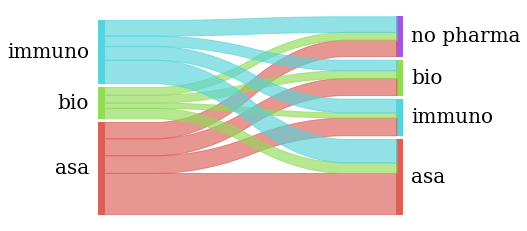

In [0]:
from pysankey import sankey

sankey(
      left=df['first_pharma'], right=df['second_pharma'],
      rightWeight=df['weight'], leftWeight=df['weight'], aspect=20, fontsize=20
);

In [0]:
pharma_order

pid_index
0076A3B03FA644E9         bi
00B22C471486C580      babia
00D3EFAF79074DAE          b
032028E477C3DECE    abaibab
03FF407305A935CE          a
                     ...   
F7389857DE9E1C4C          i
FA529C2A1EC821B3          i
FB075DB13A7173A0         ib
FB9706AEB2E28E35       ibia
FD11481CE556EC6B      aabbb
Name: pharma, Length: 286, dtype: object

### How many patients receive treatment that is not as described by the treatment pyramid?

In [0]:
# Uniqify the treatment string (i.e. aaaabbba becomes ab)
unique_order = pharma_order.apply(lambda pharma: "".join(dict.fromkeys(pharma)))

In [0]:
unique_order.value_counts()

a      55
ia     35
ai     31
i      27
abi    21
ab     18
aib    16
iba    15
b      14
bai    14
iab    13
ba     10
ib      7
bia     5
bi      5
Name: pharma, dtype: int64

In [0]:
valid_order = 'aib'

valid_first = unique_order.str[0]=='a'
valid_second = unique_order.str[:2]=='ai'
valid_third = unique_order.str[:3]=='aib'
overall_ok = valid_first.sum() + valid_second.sum() + valid_third.sum() 

In [0]:

overall_ok
overall_ok/len(unique_order)


0.7132867132867133

Conclusion: 71% of the patients have (so far) received treatment as described by the treatment pyramid, and 29% have received treatment inconsistent with the pattern described in the pyramid.
